In [ ]:
!gdown --id 155wulmctFNkAMYFp770XLCWm1FcYEsfy

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=155wulmctFNkAMYFp770XLCWm1FcYEsfy
To: /content/WordSegData2.zip
100% 10.5M/10.5M [00:00<00:00, 146MB/s]


In [ ]:
!unzip WordSegData2

Archive:  WordSegData2.zip
   creating: Dataset1/
   creating: Dataset1/img/
  inflating: Dataset1/img/lineA0.jpg  
  inflating: Dataset1/img/lineA1.jpg  
  inflating: Dataset1/img/lineA10.jpg  
  inflating: Dataset1/img/lineA11.jpg  
  inflating: Dataset1/img/lineA12.jpg  
  inflating: Dataset1/img/lineA13.jpg  
  inflating: Dataset1/img/lineA14.jpg  
  inflating: Dataset1/img/lineA15.jpg  
  inflating: Dataset1/img/lineA16.jpg  
  inflating: Dataset1/img/lineA17.jpg  
  inflating: Dataset1/img/lineA18.jpg  
  inflating: Dataset1/img/lineA19.jpg  
  inflating: Dataset1/img/lineA2.jpg  
  inflating: Dataset1/img/lineA20.jpg  
  inflating: Dataset1/img/lineA21.jpg  
  inflating: Dataset1/img/lineA22.jpg  
  inflating: Dataset1/img/lineA23.jpg  
  inflating: Dataset1/img/lineA24.jpg  
  inflating: Dataset1/img/lineA25.jpg  
  inflating: Dataset1/img/lineA26.jpg  
  inflating: Dataset1/img/lineA27.jpg  
  inflating: Dataset1/img/lineA28.jpg  
  inflating: Dataset1/img/lineA3.jpg  
  infla

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import random
import math

In [ ]:
image_list=os.listdir('/content/Dataset1/img/')
image_list=[filename.split(".")[0]for filename in image_list]

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
    
def get_segmented_img(img,n_classes):
    """
    Memasukkan gambar yang akan di segmen dan membuat label segmen yang cocok.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]
    seg_labels[:,:,0]=(img!=0).astype(int)
    return seg_labels

def pad_img(img):
	old_h,old_w=img.shape[0],img.shape[1]
	#Pad the height.
	#If height is less than 512 then pad to 512
	if old_h<512:
		to_pad=np.ones((512-old_h,old_w))*255
		img=np.concatenate((img,to_pad))
		new_height=512
	else:
	#If height >512 then pad to nearest 10.
		to_pad=np.ones((roundup(old_h)-old_h,old_w))*255
		img=np.concatenate((img,to_pad))
		new_height=roundup(old_h)

	#Pad the width.
	if old_w<512:
		to_pad=np.ones((new_height,512-old_w))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=512
	else:
		to_pad=np.ones((new_height,roundup(old_w)-old_w))*255
		img=np.concatenate((img,to_pad),axis=1)
		new_width=roundup(old_w)-old_w
	return img

def pad_seg(img):
	old_h,old_w=img.shape[0],img.shape[1]
	#Pad the height.
	#If height is less than 512 then pad to 512
	if old_h<512:
		to_pad=np.zeros((512-old_h,old_w))
		img=np.concatenate((img,to_pad))
		new_height=512
	else:
	#If height >512 then pad to nearest 10.
		to_pad=np.zeros((roundup(old_h)-old_h,old_w))
		img=np.concatenate((img,to_pad))
		new_height=roundup(old_h)
	#Pad the width.
	if old_w<512:
		to_pad=np.zeros((new_height,512-old_w))
		img=np.concatenate((img,to_pad),axis=1)
		new_width=512
	else:
		to_pad=np.zeros((new_height,roundup(old_w)-old_w))
		img=np.concatenate((img,to_pad),axis=1)
		new_width=roundup(old_w)-old_w
	return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/Dataset1/img/{fn}.jpg',0)
      img=pad_img(img)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/Dataset1/mask/{fn}_mask.png',0)
      seg=pad_seg(seg)
      seg=cv2.resize(seg,(512,512))
      seg = np.stack((seg,)*3, axis=-1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

In [ ]:
random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)
  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

model=unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 128, 128, 51  0          ['conv2d_12[0][0]']              
                                2)                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 25  524544      ['up_sampling2d_1[0][0]']        
                                6)                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 128, 51  0           ['conv2d_5[0][0]',               
                                2)                                'conv2d_13[0][0]']              
                                                                                                  
 conv2d_14

In [ ]:
image_list[0]

'linebh27'

In [ ]:
img=cv2.imread('/content/Dataset1/img/'+image_list[1]+'.jpg',1)
seg=cv2.imread('/content/Dataset1/mask/'+image_list[1]+'_mask.png',1)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(seg,cmap='gray')
plt.title('Segmented Image')
plt.show()

NameError: ignored

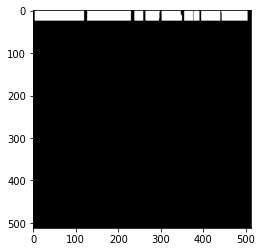

In [ ]:
img,seg=next(batch_generator(file_test,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [ ]:
mc = ModelCheckpoint('weights{epoch:08d}.h5',save_weights_only=True, period=1)
model.fit(batch_generator(file_train,2,2),epochs=5,steps_per_epoch=100,validation_data=batch_generator(file_test,2,2),validation_steps=200,callbacks=[mc],shuffle=1)

Epoch 1/5
100/100 [==============================] - 121s 985ms/step - loss: 0.0869 - accuracy: 0.9936 - val_loss: 0.0097 - val_accuracy: 0.9963
Epoch 2/5
100/100 [==============================] - 98s 987ms/step - loss: 0.0082 - accuracy: 0.9966 - val_loss: 0.0122 - val_accuracy: 0.9952
Epoch 3/5
100/100 [==============================] - 98s 986ms/step - loss: 0.0076 - accuracy: 0.9968 - val_loss: 0.0080 - val_accuracy: 0.9968
Epoch 4/5
100/100 [==============================] - 98s 986ms/step - loss: 0.0073 - accuracy: 0.9970 - val_loss: 0.0074 - val_accuracy: 0.9971
Epoch 5/5
100/100 [==============================] - 98s 987ms/step - loss: 0.0073 - accuracy: 0.9969 - val_loss: 0.0075 - val_accuracy: 0.9969


In [ ]:
file_test='/content/Dataset1/img/lineA1.jpg'
img=cv2.imread(f'{file_test}',0)
img=pad_img(img)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img=np.expand_dims(img,axis=-1)
#img = np.stack((img,)*3, axis=-1)
img=img/255

In [ ]:
plt.imshow(file_test)

1/1 [==============================] - 4s 4s/step


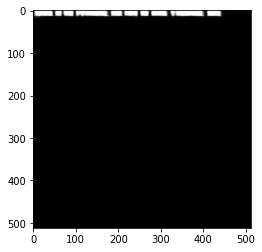

In [ ]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [ ]:
plt.imsave('test_img_mask.JPG',pred)

In [ ]:
coordinates=[]

In [ ]:
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread(f'{file_test}',0)
ori_img=pad_img(ori_img)
(H, W) = ori_img.shape[:2]
(newW, newH) = (512, 512)
rW = W / float(newW)
rH = H / float(newH)
ori_img_copy=np.stack((ori_img,)*3, axis=-1)

contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # Mencari bordir kotak
    x, y, w, h = cv2.boundingRect(c)
    # Bordir kotak divisualisasikan dengan warna merah
    cv2.rectangle(ori_img_copy, (int(x*rW), int(y*rH)), (int((x+w)*rW),int((y+h)*rH)), (255,0,0), 1)
    #coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
cv2.imwrite("output.png",ori_img_copy)

True

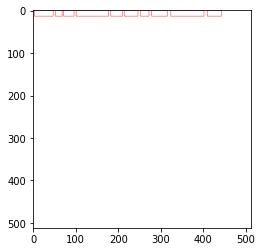

In [ ]:
plt.imshow(ori_img_copy)